In [1]:
from main import RF
from mmdit import MMDiT
import torch

rf = RF(
    MMDiT(
        in_channels=4,
        out_channels=4,
        dim=2560,
        global_conddim=2560,
        n_layers=24,
        n_heads=8,
        cond_seq_dim=1024,
    ),
    True,
).cuda()
rf.load_state_dict(torch.load("/home/host/simo/ckpts/5b_fpd/model_69633/ema1.pt", map_location="cpu"), strict = False)


/home/host/py39cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-05-17 04:20:09,851] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


<All keys matched successfully>

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
device = 'cuda:0'
t5tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-large", use_fast=False)
t5tokenizer.pad_token = t5tokenizer.bos_token
t5model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-large")
t5model = t5model.to(device).eval()

In [3]:

@torch.no_grad()
def make_cond(cond_prompts, uncond_prompts = None,):
    if not isinstance(uncond_prompts, list):
        uncond_prompts = ["bad quality, jpeg"] * len(cond_prompts)
        
    allprompts = cond_prompts + uncond_prompts

    t5_inputs = t5tokenizer(
        allprompts,
        truncation=True,
        max_length=128,
        padding="max_length",    
        return_tensors="pt",
    )
    t5_inputs = {k: v.to(device) for k, v in t5_inputs.items()}
    t5_outputs = t5model.encoder(**t5_inputs)[0] # B, T, D
    # mask that by 0 for padding tokens
    mask = t5_inputs["attention_mask"].unsqueeze(-1).expand(t5_outputs.shape)
    t5_outputs = t5_outputs * mask

    return {'c_seq': t5_outputs[:len(cond_prompts)]}, {'c_seq': t5_outputs[len(cond_prompts):]}

captions = ["photo of very cute blue cat", "photo of a black dog", "illustration of yellow chair", "fireworks in the night",
    'dark wizard', 'photo of random cat', 'rabbit with blue ears', 'tiger in the jungle',
    "A smiling sloth wearing a leather jacket, a cowboy hat, a kilt and a bowtie. The sloth is holding a quarterstaff and a big book. The sloth stands a few feet in front of a shiny VW van. The van has a cityscape painted on it and parked on grass.",
    "A DSLR photo of a shiny VW van that has a cityscape painted on it. A smiling sloth stands on grass in front of the van and is wearing a leather jacket, a cowboy hat, a kilt and a bowtie. The sloth is holding a quarterstaff and a big book.",
    "a poodle wearing a baseball cap holding a dictionary in hand and writing bonez on a chalkboard",
    "A close-up photo of a wombat wearing a red backpack and raising both arms in the air. Mount Rushmore is in the background.",
    "A single beam of light enter the room from the ceiling. The beam of light is illuminating an easel. On the easel there is a Rembrandt painting of a raccoon",
    "The buildings of downtown Manhattan situated at below Mount Everest. The Great Pyramid is in the foreground.",
    "a real flamingo reading a large open book. a big stack of books is piled up next to it. dslr photograph.",
    "a painting of black and white with a red flower in the right corner"
]

conds, unconds = make_cond(captions)


In [4]:
STEPSIZE = 50
L = len(conds['c_seq'])

init_noise = torch.randn(L, 4, 32, 32).cuda()
images = rf.sample_with_xps(init_noise, conds, null_cond = unconds, sample_steps = STEPSIZE, cfg = 5.0)

In [5]:
from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [6]:
images_for_grid = [[] for _ in range(L)]

for i, _ in enumerate(conds['c_seq'][:L]):
    for t in range(STEPSIZE):
        x = vae.decode(images[t][i : i + 1].cuda()/0.13025).sample
        img = VaeImageProcessor().postprocess(
            image=x.detach(), do_denormalize=[True, True]
        )[0]
        images_for_grid[i].append(img)

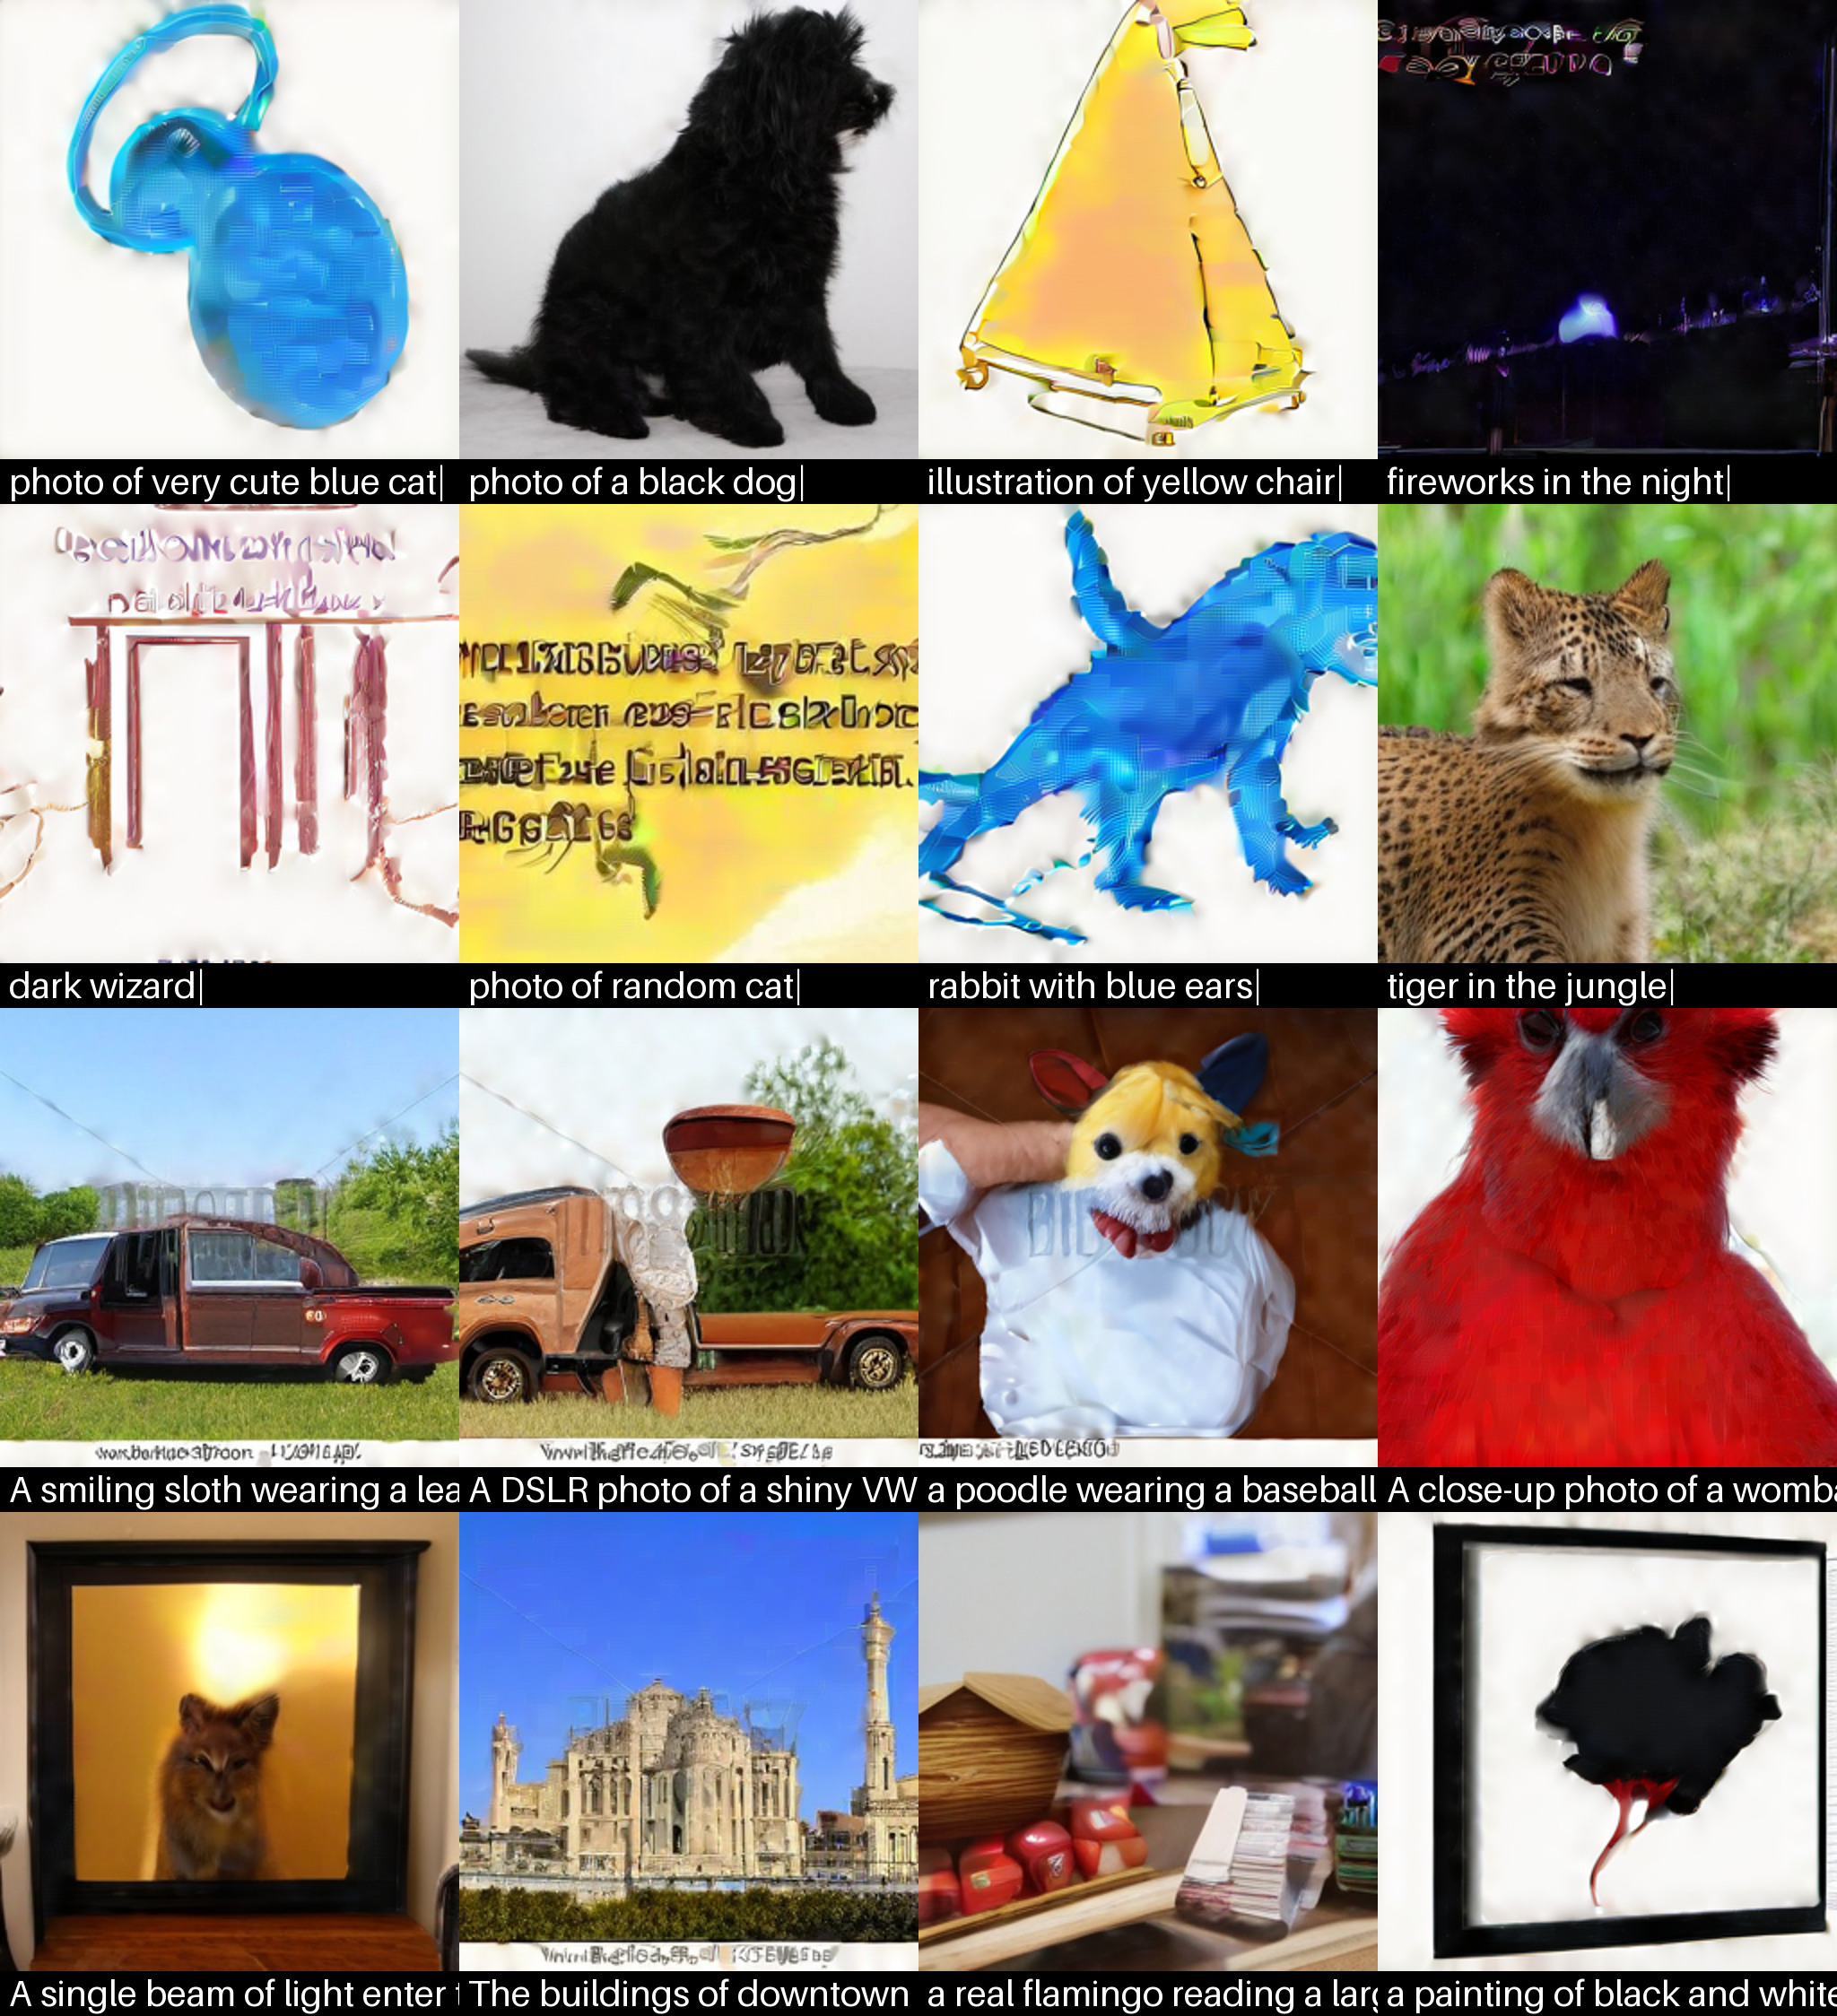

In [7]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import math

def add_caption(image, caption, font=None):
    draw = ImageDraw.Draw(image)
    width, height = image.size
    text_width, text_height = 40, 40
    text_x = 10
    text_y = height - text_height - 10  # Slightly above the bottom of the image
    draw.text((text_x, text_y), caption, fill="white", font=font)

grid_images = []
sL = math.ceil(math.sqrt(L))
show_captions = [f"{c}|" for i, c in enumerate(captions)]

# Load a font
try:
    font = ImageFont.truetype("arial.ttf", 40)
except IOError:
    font = ImageFont.load_default(40)

IW = 512
IH = 512 + 50

for t in range(STEPSIZE):
    grid = Image.new('RGB', (IW * sL, IH * sL))
    for i in range(L):
        img = images_for_grid[i][t].copy()
        # append bit of whitespace on the img
        ni = Image.new('RGB', (IW, IH))
        img = img.resize((IW, IW))
        ni.paste(img, (0, 0))
        img = ni

        add_caption(img, show_captions[i], font=font)
        grid.paste(img, (IW * (i % sL), IH * (i // sL)))
    grid_images.append(grid)

# Make it a gif and make the last image longer
grid_images += [grid_images[-1]] * 15

# Display the last image
grid_images[-1]

In [61]:
grid_images[-1].save('output_2.gif', save_all=True, append_images=grid_images[:-1], duration=100, loop=0)
